## Spaceship Titanic Data Exploration

In this notebook I'll be focusing on getting to know the data. Becuase Kaggle has already split the data, the work below will only include the train data set.

My goal is to better understand what's going on and come up with ideas for new features I can engineer.

In [100]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pear

In [137]:
# Load raw data from Github
df = pd.read_csv('https://raw.githubusercontent.com/attyfinch/spaceship_titanic_predictive_model_kaggle/main/spaceship-titanic/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# High Level Stats

In [102]:
rows, columns = df.shape
print(f'There are {rows} rows and {columns} columns')

There are 8693 rows and 14 columns


In [103]:
# Nmber of unique values for each column
df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

Name, PassengerId, and Cabin are all categorical columns with high cardinality. In their current state dropping them would be an obvious choice, it's possible all three could be used to engineer effective features.

Cabin seems like the most promising choice. Perhaps ship position indicates likliehood of being transported?

PassengerId could provide a glimpse into group sizes, and it's possible group size is correlated to survival rate.

Last, Name. This is a long shot idea, but perhaps gender can be gleaned from this info. I say this is a long shot b/c these names are obviously invented and have a futuristic bent. It's worth trying if I hit a wall, but I'm not prioritizing this.

In [12]:
# What's the death rate for the data set?
df.value_counts('Transported', normalize=True).round(3)

Transported
True     0.504
False    0.496
dtype: float64

In [ ]:
# Pair plot to find quick ideas for areas to explore
sns.pairplot(df)

# Age

In [104]:
# Mean for Transported vs not Transported
transported_mean_age = df.pivot_table(index='Transported', values='Age', aggfunc='mean')
transported_mean_age

,Age
Transported,
False,29.922858
True,27.748834


In [154]:
# Transported rate by age
df['Transported'] = df['Transported'].astype(int)

age_pivot = df.pivot_table(index='Age', values='Transported', aggfunc=['count', 'sum'])
age_pivot['transported_rate'] = age_pivot['sum'] / age_pivot['count']
age_pivot.tail(30)

,count,sum,transported_rate
,Transported,Transported,
Age,,,
50.0,74,37,0.500000
51.0,59,21,0.355932
52.0,52,28,0.538462
53.0,61,30,0.491803
54.0,67,32,0.477612
55.0,68,32,0.470588
56.0,48,22,0.458333
57.0,46,22,0.478261


<Axes: xlabel='Age', ylabel='transported_rate'>

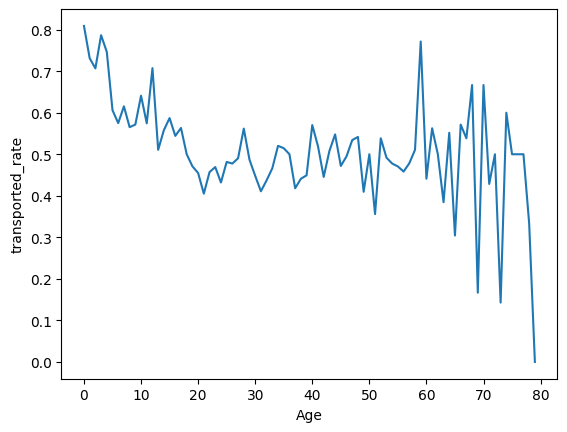

In [116]:
sns.lineplot(data=age_pivot, x='Age', y='transported_rate')

<Axes: xlabel='Age', ylabel="('count', 'Transported')">

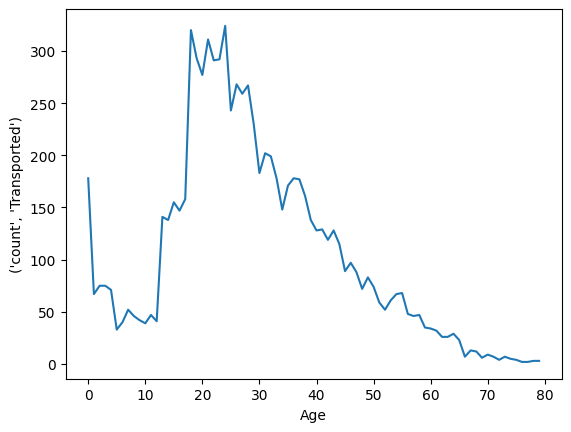

In [125]:
sns.lineplot(data=age_pivot, x='Age', y=('count', 'Transported'))

In [156]:
# Age categories, first pass
df.loc[df['Age'] < 5, 'age_cat'] = 'under_5'
df.loc[(df['Age'] >= 5) & (df['Age'] < 13), 'age_cat'] = '5 - 12'
df.loc[(df['Age'] >= 13) & (df['Age'] < 19), 'age_cat'] = '13 - 18'
df.loc[(df['Age'] >= 19) & (df['Age'] < 25), 'age_cat'] = '19 - 24'
df.loc[(df['Age'] >= 25) & (df['Age'] < 45), 'age_cat'] = '25 - 44'
df.loc[(df['Age'] >= 45) & (df['Age'] < 60), 'age_cat'] = '45 - 59'
df.loc[df['Age'] >= 60, 'age_cat'] = '60 and over'

In [157]:
# Age categegories, transported rate
age_cat_pivot = df.pivot_table(index='age_cat', values='Transported', aggfunc='mean')
age_cat_pivot

,Transported
age_cat,
13 - 18,0.537299
19 - 24,0.447427
25 - 44,0.483568
45 - 59,0.491886
5 - 12,0.605882
60 and over,0.468504
under_5,0.768240


### Age notes

- Population is right skewed, meaning most passengers are under 40
- Mean age of transported 2 years lower than not transported population
- Under 10 heavily skewed Transported, under 18 also skewed, but less so.
- There's wrinkles in other age groups. Engineering age bracket feature will likely improve predictions, but I'll need to spend some time tuning to find the best groupings.

# Cryo Sleep

In [148]:
df['CryoSleep'] = df['CryoSleep'].astype(float)
df['Transported'] = df['Transported'].astype(int)

df['CryoSleep'].value_counts(normalize=True)

0.0    0.641694
1.0    0.358306
Name: CryoSleep, dtype: float64

In [150]:
cryo_pivot = df.pivot_table(index='CryoSleep', values='Transported', aggfunc=['count', 'sum'])
cryo_pivot['transported_rate'] = cryo_pivot['sum'] / cryo_pivot['count']
cryo_pivot

,count,sum,transported_rate
,Transported,Transported,
CryoSleep,,,
0.0,5439,1789,0.328921
1.0,3037,2483,0.817583


<Axes: xlabel='Age', ylabel='cryo_sleep_rate'>

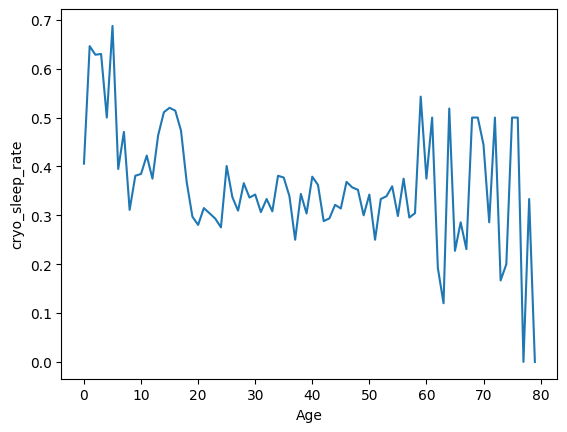

In [153]:
cryo_age_pivot = df.pivot_table(index='Age', values='CryoSleep', aggfunc=['count', 'sum'])
cryo_age_pivot['cryo_sleep_rate'] = cryo_age_pivot['sum'] / cryo_age_pivot['count']
sns.lineplot(data=cryo_age_pivot, x='Age', y='cryo_sleep_rate')

Cryo Sleep notes
- 64% not in cryo sleep
- Passengers in cryo sleep have a transported rate of 80%!
- % of population under 18 in cryo sleep exceeds the mean of 35%, esp among young children. This explains why this population has a higher transported rate.

# VIP

In [158]:
vip_pivot = df.pivot_table(index='VIP', values='Transported', aggfunc=['count', 'sum'])
vip_pivot['transported_rate'] = vip_pivot['sum'] / vip_pivot['count']
vip_pivot

,count,sum,transported_rate
,Transported,Transported,
VIP,,,
False,8291,4198,0.506332
True,199,76,0.381910


VIP doesn't look to be that impactful of a category. Only around 2.3% passengers are VIPs. As expected, the transported rate is lower for VIPs, but it's not dramatically lower than the mean 50% vs. 38%

# Locations

In [159]:
destination_pivot = df.pivot_table(index='Destination', values='Transported', aggfunc=['count', 'sum'])
destination_pivot['transported_rate'] = destination_pivot['sum'] / destination_pivot['count']
destination_pivot

,count,sum,transported_rate
,Transported,Transported,
Destination,,,
55 Cancri e,1800,1098,0.610000
PSO J318.5-22,796,401,0.503769
TRAPPIST-1e,5915,2787,0.471175


In [160]:
home_pivot = df.pivot_table(index='HomePlanet', values='Transported', aggfunc=['count', 'sum'])
home_pivot['transported_rate'] = home_pivot['sum'] / home_pivot['count']
home_pivot

,count,sum,transported_rate
,Transported,Transported,
HomePlanet,,,
Earth,4602,1951,0.423946
Europa,2131,1404,0.658846
Mars,1759,920,0.523024


In [163]:
df['travel_path'] = df['HomePlanet'] + ' to ' + df['Destination']

travel_pivot = df.pivot_table(index='travel_path', values='Transported', aggfunc=['count', 'sum'])
travel_pivot['transported_rate'] = travel_pivot['sum'] / travel_pivot['count']
travel_pivot

,count,sum,transported_rate
,Transported,Transported,
travel_path,,,
Earth to 55 Cancri e,690,348,0.504348
Earth to PSO J318.5-22,712,355,0.498596
Earth to TRAPPIST-1e,3101,1207,0.389229
Europa to 55 Cancri e,886,611,0.689616
Europa to PSO J318.5-22,19,14,0.736842
Europa to TRAPPIST-1e,1189,755,0.634987
Mars to 55 Cancri e,193,118,0.611399
Mars to PSO J318.5-22,49,22,0.448980


The combination of home planet and destination looks to be a feature worth working on. There are a few categories that deviate heavily from mean transportion rate and might prove useful.

# Group Size


In [175]:
# Passenger Id - creating group_num and group_id features
# group_num = grouping of passengers
# group_id = id of passenger within group

df['group_num'] = df['PassengerId'].str.split('_').str[0]
df['group_id'] = df['PassengerId'].str.split('_').str[1]

groups = df['group_num'].nunique()
avg_group_size = df['group_num'].value_counts().mean().round(2)

group_df = df[['group_num', 'group_id', 'Transported']]
group_df['Transported'] = group_df['Transported'].astype(int)

print(f'There are {groups} groups of passengers with an average size of {avg_group_size} people')

There are 6217 groups of passengers with an average size of 1.4 people


<ipython-input-175-97282f54f96f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df['Transported'] = group_df['Transported'].astype(int)


1    0.77
2    0.14
3    0.05
4    0.02
5    0.01
7    0.01
6    0.00
8    0.00
Name: size, dtype: float64

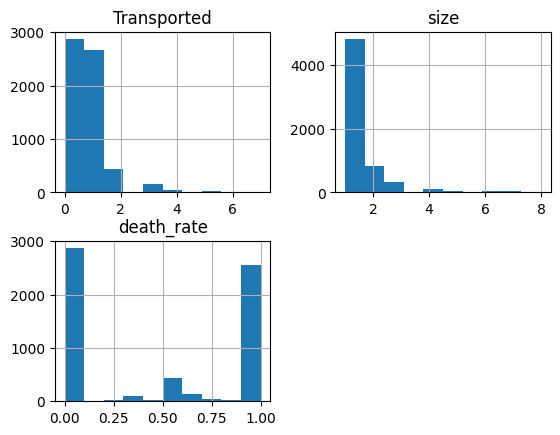

In [187]:
# # Group size distribution
group_by_size = group_df.pivot_table(index='group_num', values=['group_id', 'Transported'], aggfunc={'group_id': 'count', 'Transported': 'sum'})
group_by_size = group_by_size.rename(columns={'group_id': 'size'})
group_by_size['death_rate'] = (group_by_size['Transported'] / group_by_size['size']).round(2)

# # Histogram + numbers
group_size_dist = group_by_size.hist()
group_by_size['size'].value_counts(normalize=True).round(2)

In [198]:
group_df

,group_num,group_id,Transported
0,0001,01,0
1,0002,01,1
2,0003,01,0
3,0003,02,0
4,0004,01,1
...,...,...,...
8688,9276,01,0
8689,9278,01,0
8690,9279,01,1
8691,9280,01,0


The vast majority, 77% to be exact, are not actually groups, they are solo passengers travelling alone. Fourteen percent are couples, and the remaining 8% are comprised of 3 or more people. These groups are most likely families.

This could make for an effective feature with 3 categories: solo, couple, family. I should add to the list for the model building/tuning process.

# Ammenities

In [215]:
# Ammenities features
df['ammenities_spend'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
df['used ammenities'] = df['ammenities_spend'] > 0

df['ammenities_spend'].isna().sum()
df.loc[df['ammenities_spend'].isna(), 'used ammenities'] = 0
df.loc[df['used ammenities'].isna(), 'used ammenities'] = 0

In [216]:
# Ammenities used w/ transported rates
ammenities_pivot = df.pivot_table(index='used ammenities', values='Transported', aggfunc=['count', 'sum'])
ammenities_pivot['transported_rate'] = ammenities_pivot['sum'] / ammenities_pivot['count']
ammenities_pivot

,count,sum,transported_rate
,Transported,Transported,
used ammenities,,,
False,4155,3011,0.724669
True,4538,1367,0.301234


In [217]:
# Ammenities spend
amm_spend_pivot = df.pivot_table(index='used ammenities', values='ammenities_spend', aggfunc=['count', 'sum', 'mean'])
amm_spend_pivot

,count,sum,mean
,ammenities_spend,ammenities_spend,ammenities_spend
used ammenities,,,
False,3247,0.0,0.0000
True,4538,11557623.0,2546.8539


In [230]:
# Trying to beat 72%

threshold = 500
df['amm_thresh'] = df['ammenities_spend'] < threshold
df['amm_thresh'] = df['amm_thresh'].astype(int)

amm_thresh_pivot = df.pivot_table(index='amm_thresh', values='Transported', aggfunc=['count', 'sum'], margins=True)
amm_thresh_pivot['transported_rate'] = amm_thresh_pivot['sum'] / amm_thresh_pivot['count']
amm_thresh_pivot

,count,sum,transported_rate
,Transported,Transported,
amm_thresh,,,
0,5425,1829,0.337143
1,3268,2549,0.779988
All,8693,4378,0.503624


In [237]:
# Setting binary columns for ammenities
# Looking at pearson's corr for each
df['used_vr'] = df['VRDeck'] > 0
df['used_vr'] = df['used_vr'].astype(int)

df['used_spa'] = df['Spa'] > 0
df['ued_spa'] = df['ued_spa'].astype(int)

df['used_shopping'] = df['ShoppingMall'] > 0
df['used_shopping'] = df['used_shopping'].astype(int)

df['used_room'] = df['RoomService'] > 0
df['used_room'] = df['used_room'].astype(int)

df['used_food'] = df['FoodCourt'] > 0
df['used_food'] = df['used_food'].astype(int)

for col in ['used_vr', 'used_spa', 'used_shopping', 'used_room', 'used_food']:
  print(col, np.corrcoef(df[col], df['Transported']))

used_vr [[ 1.         -0.33217527]
 [-0.33217527  1.        ]]
used_spa [[ 1.         -0.34405032]
 [-0.34405032  1.        ]]
used_shopping [[ 1.         -0.26379233]
 [-0.26379233  1.        ]]
used_room [[ 1.         -0.34792827]
 [-0.34792827  1.        ]]
used_food [[ 1.         -0.23281596]
 [-0.23281596  1.        ]]


Grouping ammenities by spend and as binary column of used/not-used looks to be effective at teasing out transportation rates. Those not using ammenities are far more likely to be transported than those using ammenities.

Looking at individual ammenities, VR, Spa, and Room Service use are more highly correlated with survival rates. While Shopping and Food Court are less correlated with survival rates, their use still indicates a higher chance of not being transported.

# Cabin

In [249]:
# Splitting Cabin
df['deck'] = df['Cabin'].str.split('/').str[0]
df['num'] = df['Cabin'].str.split('/').str[1]
df['side'] = df['Cabin'].str.split('/').str[2]

In [250]:
deck_pivot = df.pivot_table(index='deck', values='Transported', aggfunc=['count', 'sum'])
deck_pivot['transported_rate'] = deck_pivot['sum'] / deck_pivot['count']
deck_pivot

,count,sum,transported_rate
,Transported,Transported,
deck,,,
A,256,127,0.496094
B,779,572,0.734275
C,747,508,0.680054
D,478,207,0.433054
E,876,313,0.357306
F,2794,1229,0.439871
G,2559,1321,0.516217
T,5,1,0.200000


In [251]:
num_pivot = df.pivot_table(index='num', values='Transported', aggfunc=['count', 'sum'])
num_pivot['transported_rate'] = num_pivot['sum'] / num_pivot['count']
num_pivot

,count,sum,transported_rate
,Transported,Transported,
num,,,
0,18,6,0.333333
1,15,10,0.666667
10,12,6,0.500000
100,12,7,0.583333
1000,6,3,0.500000
...,...,...,...
995,3,2,0.666667
996,1,1,1.000000


In [252]:
side_pivot = df.pivot_table(index='side', values='Transported', aggfunc=['count', 'sum'])
side_pivot['transported_rate'] = side_pivot['sum'] / side_pivot['count']
side_pivot

,count,sum,transported_rate
,Transported,Transported,
side,,,
P,4206,1898,0.451260
S,4288,2380,0.555037


Deck looks like it may be an effective feature. Number and side seem to be less interesting.

# Notes


### Column explanations

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.


**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Destination** - The planet the passenger will be debarking to.

**Age** - The age of the passenger.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

**Name** - The first and last names of the passenger.

**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.